## Package & Data Imports

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install pyspellchecker
!pip install py-readability-metrics
!pip install textstat
!pip install pyarrow
!pip install transformers
!pip install tqdm
!pip install datasets
!pip install tensorflow
!pip install torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 63.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.1/105.1 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 48.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 18.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 19.5 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requir

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import torch

import textstat
from sklearn.feature_extraction.text import CountVectorizer
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from spellchecker import SpellChecker
from readability import Readability

from transformers import pipeline
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from transformers import Trainer, TrainingArguments
from transformers import TFAutoModelForSequenceClassification

from datasets import Dataset

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error

import gc
from tqdm import tqdm


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
# Import review data

chunk_size = 100000  # read 100k rows
yelp_data_full = pd.DataFrame()

with pd.read_json('/content/drive/MyDrive/Code + Data/yelp_academic_dataset_review.json', lines=True, chunksize=chunk_size) as reader:
    for i, chunk in enumerate(reader):
        yelp_data_full = pd.concat([yelp_data_full, chunk], ignore_index=True)
        del chunk
        gc.collect()

        if (i + 1) % 5 == 0:
            print(f'progress {(i + 1)} / 70')

progress 5 / 70
progress 10 / 70
progress 15 / 70
progress 20 / 70
progress 25 / 70
progress 30 / 70
progress 35 / 70
progress 40 / 70
progress 45 / 70
progress 50 / 70
progress 55 / 70
progress 60 / 70
progress 65 / 70
progress 70 / 70


In [ ]:
print(len(yelp_data_full))
yelp_data = yelp_data_full
del yelp_data_full
gc.collect()

6990280


0

In [ ]:
yelp_business_data_full = pd.read_json('/content/drive/MyDrive/Code + Data/yelp_academic_dataset_business.json', lines=True)

In [ ]:
# Check shapes of yelp_data and yelp_business_data_full
print(yelp_data.shape)
print('columns:', yelp_data.columns)
print(yelp_business_data_full.shape)
print('columns:', yelp_business_data_full.columns)

(6990280, 9)
columns: Index(['review_id', 'user_id', 'business_id', 'stars', 'useful', 'funny',
       'cool', 'text', 'date'],
      dtype='object')
(150346, 14)
columns: Index(['business_id', 'name', 'address', 'city', 'state', 'postal_code',
       'latitude', 'longitude', 'stars', 'review_count', 'is_open',
       'attributes', 'categories', 'hours'],
      dtype='object')


In [ ]:
# Merge business data into full dataset
yelp_data = pd.merge(yelp_data, yelp_business_data_full, on=['business_id'], how='inner')

In [ ]:
print(yelp_data.shape)
print('------------------------------')
print('columns:', yelp_data.columns)
print('------------------------------')
print(yelp_data.info())
print('------------------------------')
print(yelp_data.head())

(6990280, 22)
------------------------------
columns: Index(['review_id', 'user_id', 'business_id', 'stars_x', 'useful', 'funny',
       'cool', 'text', 'date', 'name', 'address', 'city', 'state',
       'postal_code', 'latitude', 'longitude', 'stars_y', 'review_count',
       'is_open', 'attributes', 'categories', 'hours'],
      dtype='object')
------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6990280 entries, 0 to 6990279
Data columns (total 22 columns):
 #   Column        Dtype         
---  ------        -----         
 0   review_id     object        
 1   user_id       object        
 2   business_id   object        
 3   stars_x       int64         
 4   useful        int64         
 5   funny         int64         
 6   cool          int64         
 7   text          object        
 8   date          datetime64[ns]
 9   name          object        
 10  address       object        
 11  city          object        
 12  state         object      

In [ ]:
print(yelp_data.iloc[0])

review_id                                  KU_O5udG6zpxOg-VcAEodg
user_id                                    mh_-eMZ6K5RLWhZyISBhwA
business_id                                XQfwVwDr-v0ZS3_CbbE5Xw
stars_x                                                         3
useful                                                          0
funny                                                           0
cool                                                            0
text            If you decide to eat here, just be aware it is...
date                                          2018-07-07 22:09:11
name                                 Turning Point of North Wales
address                                       1460 Bethlehem Pike
city                                                  North Wales
state                                                          PA
postal_code                                                 19454
latitude                                                40.210196
longitude 

In [ ]:
print(yelp_data.isnull().sum())

review_id            0
user_id              0
business_id          0
stars_x              0
useful               0
funny                0
cool                 0
text                 0
date                 0
name                 0
address              0
city                 0
state                0
postal_code          0
latitude             0
longitude            0
stars_y              0
review_count         0
is_open              0
attributes      183723
categories         689
hours           398286
dtype: int64


In [ ]:
print(yelp_data.describe())

            stars_x        useful         funny          cool  \
count  6.990280e+06  6.990280e+06  6.990280e+06  6.990280e+06   
mean   3.748584e+00  1.184609e+00  3.265596e-01  4.986175e-01   
min    1.000000e+00 -1.000000e+00 -1.000000e+00 -1.000000e+00   
25%    3.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
50%    4.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
75%    5.000000e+00  1.000000e+00  0.000000e+00  0.000000e+00   
max    5.000000e+00  1.182000e+03  7.920000e+02  4.040000e+02   
std    1.478705e+00  3.253767e+00  1.688729e+00  2.172460e+00   

                                date      latitude     longitude  \
count                        6990280  6.990280e+06  6.990280e+06   
mean   2017-01-11 11:22:33.441780992  3.594839e+01 -8.972830e+01   
min              2005-02-16 03:23:22  2.755513e+01 -1.200951e+02   
25%    2015-01-25 04:53:50.249999872  2.996448e+01 -9.030510e+01   
50%              2017-06-03 01:26:07  3.860392e+01 -8.621077e+01   
75%   

## Data Cleaning

In [ ]:
yelp_data.columns

Index(['review_id', 'user_id', 'business_id', 'stars_x', 'useful', 'funny',
       'cool', 'text', 'date', 'name', 'address', 'city', 'state',
       'postal_code', 'latitude', 'longitude', 'stars_y', 'review_count',
       'is_open', 'attributes', 'categories', 'hours'],
      dtype='object')

In [ ]:
# Drop unnecessary columns and rename stars columns
columns_to_drop = ['funny', 'cool', 'date', 'address', 'city', 'state',
                   'latitude', 'longitude', 'is_open', 'attributes', 'hours', 'review_count'] # dropping review_count since it wont be accurate

yelp_data.rename({'stars_x': 'stars_reviewer', 'stars_y': 'stars_business'}, axis='columns', inplace=True)

yelp_data.drop(columns_to_drop, axis=1, inplace=True)

print(yelp_data.shape)

(6990280, 10)


In [ ]:
yelp_business_data_full.drop(['review_count'], axis=1, inplace=True)

In [ ]:
print(yelp_data.columns)
print(yelp_business_data_full.columns )

Index(['review_id', 'user_id', 'business_id', 'stars_reviewer', 'useful',
       'text', 'name', 'postal_code', 'stars_business', 'categories'],
      dtype='object')
Index(['business_id', 'name', 'address', 'city', 'state', 'postal_code',
       'latitude', 'longitude', 'stars', 'is_open', 'attributes', 'categories',
       'hours'],
      dtype='object')


In [ ]:
# add number of reviews for each business column to yelp_business_data_full
total_reviews = yelp_data.groupby('business_id').size().reset_index(name='total_num_reviews')
yelp_business_data_full = yelp_business_data_full.merge(total_reviews, on='business_id', how='left')
print(yelp_business_data_full.head())

              business_id                      name  \
0  Pns2l4eNsfO8kk83dixA6A  Abby Rappoport, LAC, CMQ   
1  mpf3x-BjTdTEA3yCZrAYPw             The UPS Store   
2  tUFrWirKiKi_TAnsVWINQQ                    Target   
3  MTSW4McQd7CbVtyjqoe9mw        St Honore Pastries   
4  mWMc6_wTdE0EUBKIGXDVfA  Perkiomen Valley Brewery   

                           address           city state postal_code  \
0           1616 Chapala St, Ste 2  Santa Barbara    CA       93101   
1  87 Grasso Plaza Shopping Center         Affton    MO       63123   
2             5255 E Broadway Blvd         Tucson    AZ       85711   
3                      935 Race St   Philadelphia    PA       19107   
4                    101 Walnut St     Green Lane    PA       18054   

    latitude   longitude  stars  is_open  \
0  34.426679 -119.711197    5.0        0   
1  38.551126  -90.335695    3.0        1   
2  32.223236 -110.880452    3.5        0   
3  39.955505  -75.155564    4.0        1   
4  40.338183  -75.4716

In [ ]:
# adding number of reviews to yelp_data
yelp_data = yelp_data.merge(
    yelp_business_data_full[['business_id', 'total_num_reviews']],
    on='business_id',
    how='left'
)

yelp_data.rename(columns={'total_num_reviews': 'total_reviews_for_business'}, inplace=True)

In [ ]:
## cross refrence checks
print(yelp_data.head(2))
print('------------------------------------------------------------')
specific_business_row = yelp_business_data_full[yelp_business_data_full['business_id'] == '7ATYjTIgM3jUlt4UM3IypQ'] # checking the 2nd element, should be 151 total reviews in both dfs
print(specific_business_row)
print('------------------------------------------------------------')

print(yelp_business_data_full.head())
print('------------------------------------------------------------')
specific_business_row = yelp_data[yelp_data['business_id'] == 'MTSW4McQd7CbVtyjqoe9mw'] # checking the 4th element (St Honore Pastries) from 2 cells above, should be 87 total reviews in both dfs
print(specific_business_row)

                review_id                 user_id             business_id  \
0  KU_O5udG6zpxOg-VcAEodg  mh_-eMZ6K5RLWhZyISBhwA  XQfwVwDr-v0ZS3_CbbE5Xw   
1  BiTunyQ73aT9WBnpR9DZGw  OyoGAe7OKpv6SyGZT5g77Q  7ATYjTIgM3jUlt4UM3IypQ   

   stars_reviewer  useful                                               text  \
0               3       0  If you decide to eat here, just be aware it is...   
1               5       1  I've taken a lot of spin classes over the year...   

                           name postal_code  stars_business  \
0  Turning Point of North Wales       19454             3.0   
1    Body Cycle Spinning Studio       19119             5.0   

                                          categories  \
0  Restaurants, Breakfast & Brunch, Food, Juice B...   
1  Active Life, Cycling Classes, Trainers, Gyms, ...   

   total_reviews_for_business  
0                         175  
1                         151  
------------------------------------------------------------
           

In [ ]:
# add helpful column- this will be our ground truth
# helpful = number of useful votes on a review / total number of helpful votes across all reviews for that business
total_helpful_votes_per_business = yelp_data.groupby('business_id')['useful'].transform('sum')
yelp_data['helpful'] = yelp_data['useful'] / total_helpful_votes_per_business

yelp_data[['review_id','business_id', 'useful', 'helpful']].head()

,review_id,business_id,useful,helpful
0,KU_O5udG6zpxOg-VcAEodg,XQfwVwDr-v0ZS3_CbbE5Xw,0,0.000000
1,BiTunyQ73aT9WBnpR9DZGw,7ATYjTIgM3jUlt4UM3IypQ,1,0.004739
2,saUsX_uimxRlCVr67Z4Jig,YjUWPpI6HXG530lwP-fb2A,0,0.000000
3,AqPFMleE6RsU23_auESxiA,kxX2SOes4o-D3ZQBkiMRfA,1,0.003311
4,Sx8TMOWLNuJBWer-0pcmoA,e4Vwtrqf-wpJfwesgvdgxQ,1,0.031250


In [ ]:
# cross reference check for helpful_score
total_useful_votes = yelp_data[yelp_data['business_id'] == 'kxX2SOes4o-D3ZQBkiMRfA']['useful'].sum() # checking the 4th element
print(f'total_useful_votes for the business: {total_useful_votes}')
print('-------------------------')
print(yelp_data[yelp_data['review_id'] == 'AqPFMleE6RsU23_auESxiA'][['review_id', 'useful']])
print('-------------------------')
print(f'useful votes / total useful votes for the business (helpful score) {1/302}')

total_useful_votes for the business: 302
-------------------------
                review_id  useful
3  AqPFMleE6RsU23_auESxiA       1
-------------------------
useful votes / total useful votes for the business (helpful score) 0.0033112582781456954


In [ ]:
yelp_data['helpful'].isna().sum()
# business that have no reviews that are helpful.

21556

In [ ]:
# drop rows where helpful = na
yelp_data = yelp_data.dropna(subset=['helpful'])

In [ ]:
yelp_data['helpful'].isna().sum()

0

In [ ]:
# run only ONCE; takes 18 min to run. results are saved to a csv below
import nltk
nltk.download('punkt_tab')
## number of sentences for each review
def count_sentences(text):
  sentences = sent_tokenize(text)
  return len(sentences)

yelp_data['num_sentences'] = yelp_data['text'].apply(count_sentences)

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [ ]:
percentiles = [5, 10, 25, 50, 75, 90, 95]

# Group 'business_id' to get total reviews for each business
business_review_counts = yelp_data.groupby('business_id')['review_id'].count()

percentile_values = np.percentile(business_review_counts.values, percentiles)

for p, value in zip(percentiles, percentile_values):
    print(f"{p}th percentile: {value}")

5th percentile: 5.0
10th percentile: 6.0
25th percentile: 8.0
50th percentile: 16.0
75th percentile: 39.0
90th percentile: 103.0
95th percentile: 183.0


In [ ]:
print(yelp_data.shape)
# drop reviews for businesses where total reviews < 350. Doing this for computational limitations
yelp_data = yelp_data[yelp_data['total_reviews_for_business'] >= 350].reset_index(drop=True)
print(yelp_data.shape)

(6968724, 13)
(1872289, 13)


In [ ]:
# rechecking percentiles after drop
percentiles = [5, 10, 25, 50, 75, 90, 95]

# Group 'business_id' to get total reviews for each business
business_review_counts = yelp_data.groupby('business_id')['review_id'].count()

percentile_values = np.percentile(business_review_counts.values, percentiles)

for p, value in zip(percentiles, percentile_values):
    print(f"{p}th percentile: {value}")

5th percentile: 359.0
10th percentile: 371.0
25th percentile: 410.0
50th percentile: 515.0
75th percentile: 720.0
90th percentile: 1125.8000000000002
95th percentile: 1556.6000000000008


In [ ]:
print(yelp_data.shape)

(1872289, 13)


In [ ]:
# save dataframe to csv so above cells dont have to be read, do only once
# yelp_data.to_csv("/content/drive/MyDrive/Code + Data/yelp_dataset_for_model.csv", index=False)

In [ ]:
## read yelp_dataset_for_model.csv
chunk_size = 100000

# Initialize an empty DataFrame to concatenate chunks
yelp_data_full = pd.DataFrame()

# Read CSV in chunks
with pd.read_csv('/content/drive/MyDrive/Code + Data/yelp_dataset_for_model.csv', chunksize=chunk_size) as reader:
    for i, chunk in enumerate(reader):
        yelp_data_full = pd.concat([yelp_data_full, chunk], ignore_index=True)
        del chunk
        gc.collect()

        if (i + 1) % 5 == 0:
            print(f'Progress: {(i + 1) * chunk_size} rows processed')

Progress: 500000 rows processed


<ipython-input-29-e4c85cbedaa8>:9: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(reader):
<ipython-input-29-e4c85cbedaa8>:9: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(reader):


Progress: 1000000 rows processed
Progress: 1500000 rows processed


<ipython-input-29-e4c85cbedaa8>:9: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(reader):


In [ ]:
print(len(yelp_data_full))
yelp_data = yelp_data_full
del yelp_data_full

1872289


In [ ]:
print(yelp_data.isnull().sum())

review_id                       0
user_id                         1
business_id                     1
stars_reviewer                  1
useful                          2
text                            1
name                            2
postal_code                   284
stars_business                  3
categories                      3
total_reviews_for_business      3
helpful                         3
num_sentences                   3
dtype: int64


In [ ]:
print(yelp_data.columns)
yelp_data['useful'] = pd.to_numeric(yelp_data['useful'], errors='coerce')

Index(['review_id', 'user_id', 'business_id', 'stars_reviewer', 'useful',
       'text', 'name', 'postal_code', 'stars_business', 'categories',
       'total_reviews_for_business', 'helpful', 'num_sentences'],
      dtype='object')


In [ ]:
yelp_data = yelp_data.dropna(subset=['text'])
yelp_data = yelp_data.dropna(subset=['useful'])
yelp_data = yelp_data.dropna(subset=['postal_code'])
print(yelp_data.isnull().sum())

review_id                     0
user_id                       0
business_id                   0
stars_reviewer                0
useful                        0
text                          0
name                          0
postal_code                   0
stars_business                0
categories                    0
total_reviews_for_business    0
helpful                       0
num_sentences                 0
dtype: int64


## EDA

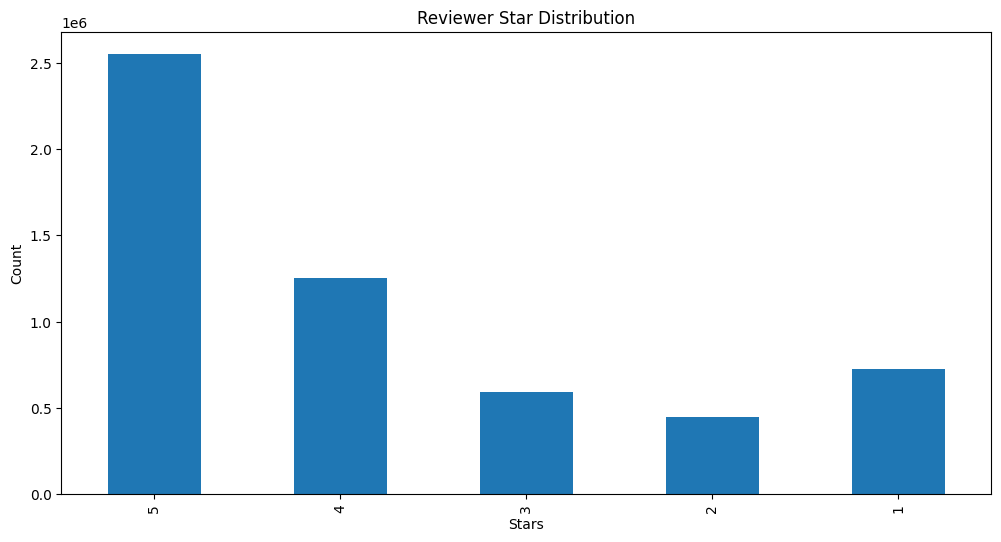

In [ ]:
fig, axes = plt.subplots(nrows=1, figsize=(12, 6))
yelp_data['stars_reviewer'].value_counts().reindex([5,4,3,2,1]).plot(kind='bar')
plt.title('Reviewer Star Distribution')
plt.xlabel('Stars')
plt.ylabel('Count')
plt.show()

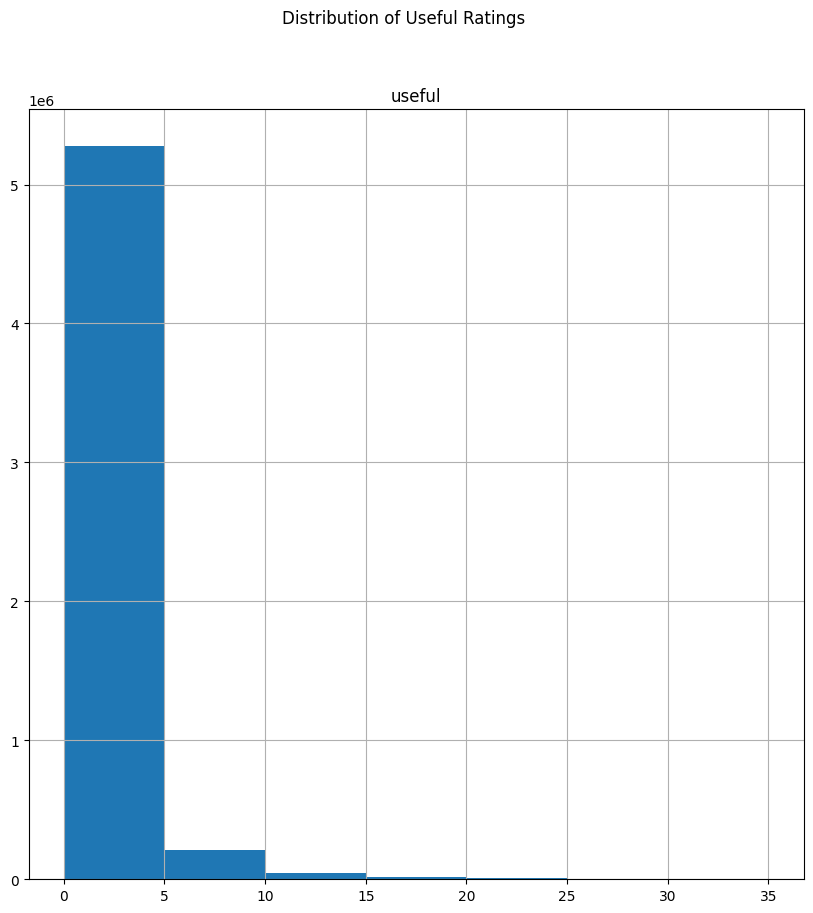

In [ ]:
bin_sizes = [0, 5, 10, 15, 20, 25, 30, 35]
yelp_data[['useful']].hist(bins= bin_sizes, figsize= (10, 10))
plt.suptitle('Distribution of Useful Ratings')
plt.show()

In [ ]:
# total number of *characters* in each review
yelp_data['num_characters'] = yelp_data['text'].apply(len)

Text(0, 0.5, 'Frequency')

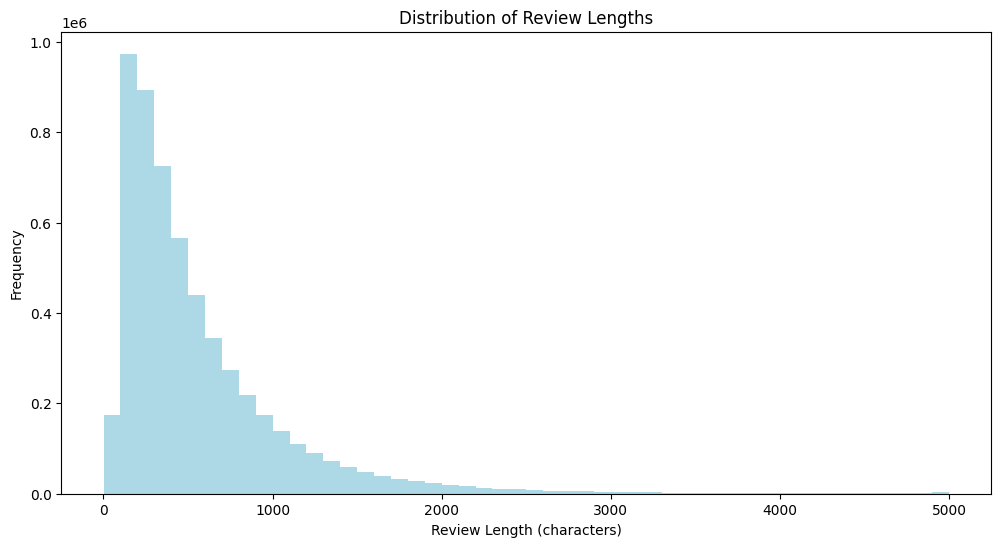

In [ ]:
fig, axes= plt.subplots(nrows=1, figsize=(12, 6))
yelp_data['num_characters'].plot(kind='hist', bins=50, color='lightblue')
plt.title('Distribution of Review Lengths')
plt.xlabel('Review Length (characters)')
plt.ylabel('Frequency')

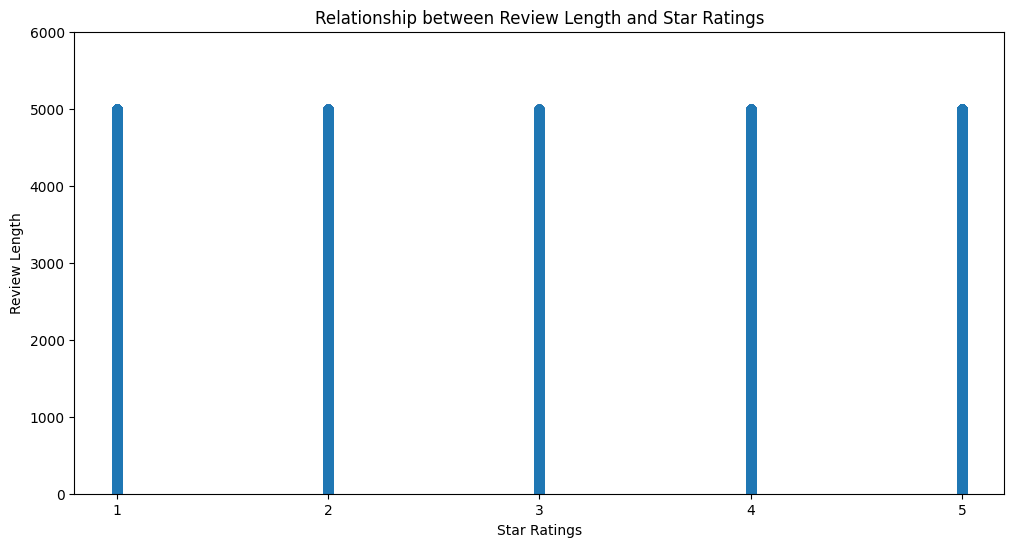

In [ ]:
## Relationship between review length and star ratings
plt.figure(figsize=(12,6))
plt.scatter(yelp_data['stars_reviewer'], yelp_data['num_characters'], alpha=.5)
plt.title('Relationship between Review Length and Star Ratings')
plt.xlabel('Star Ratings')
plt.ylabel('Review Length')
plt.xticks([1, 2, 3, 4, 5])
plt.ylim(0, 6000)
plt.show()

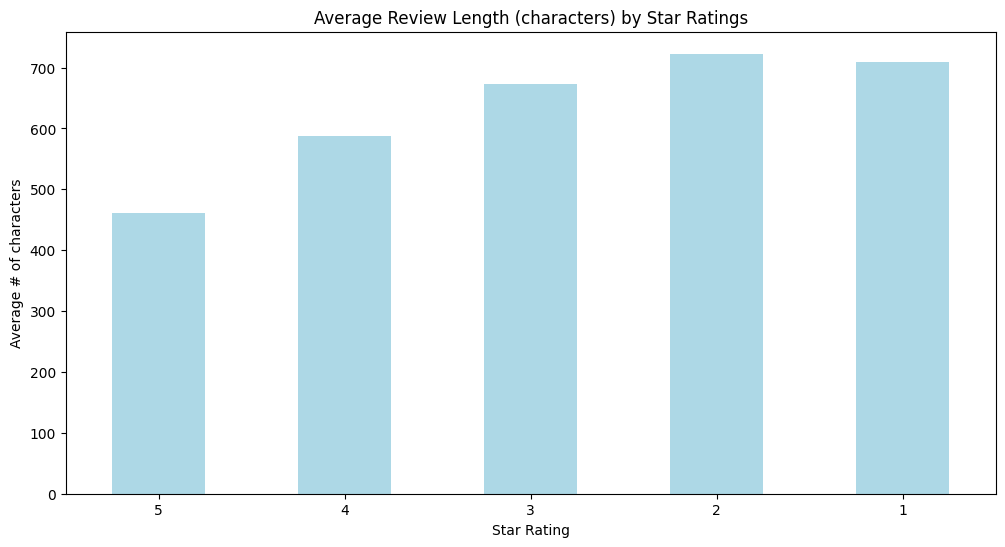

In [ ]:
average_review_length_by_star = yelp_data.groupby('stars_reviewer')['num_characters'].mean()

plt.figure(figsize=(12,6))
average_review_length_by_star.reindex([5,4,3,2,1]).plot(kind='bar', color='lightblue')
plt.title('Average Review Length (characters) by Star Ratings')
plt.xlabel('Star Rating')
plt.ylabel('Average # of characters')
plt.xticks(rotation=0)
plt.show()

                stars_reviewer    useful  num_characters
stars_reviewer        1.000000 -0.068273       -0.189478
useful               -0.068273  1.000000        0.241766
num_characters       -0.189478  0.241766        1.000000


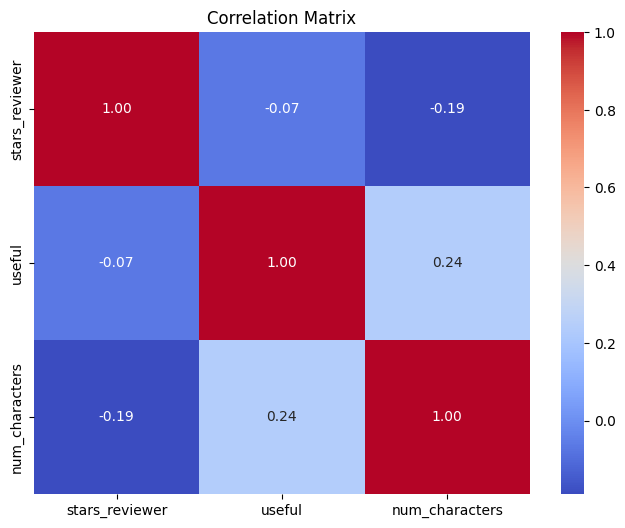

In [ ]:
correlation_matrix = yelp_data[['stars_reviewer', 'useful', 'num_characters']].corr()
print(correlation_matrix)

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()


In [ ]:
# ## Print most common words
vectorizer = CountVectorizer(stop_words='english', max_features=20)
X = vectorizer.fit_transform(yelp_data['text'])

word_counts = X.sum(axis=0)
words_freq = [(word, word_counts[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)

print(words_freq[:10])

del X, word_counts, vectorizer
gc.collect()

In [ ]:
yelp_data['num_sentences'].mean()

In [ ]:
fig, axes = plt.subplots(nrows=1, figsize=(12, 6))
bin_sizes = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50]
yelp_data['num_sentences'].plot(kind='hist', bins=bin_sizes, color='lightblue')
plt.title('Distribution of Number of Sentences in Reviews')

In [ ]:
def word_count(line):
  return len(line.split())

In [ ]:
## number of words
yelp_data['num_words'] = yelp_data['text'].apply(lambda x: word_count(x))
print(yelp_data.iloc[0][['num_characters', 'num_words']])

num_characters    513
num_words         101
Name: 0, dtype: object


Text(0.5, 1.0, 'Distribution of Number of Sentences in Reviews')

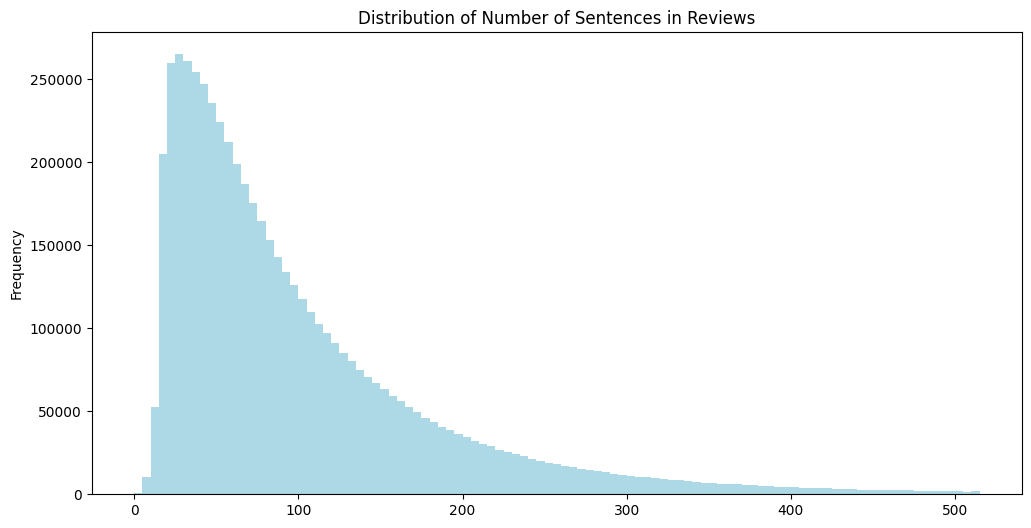

In [ ]:
## distrbution of words in reviews
fig, axes = plt.subplots(nrows=1, figsize=(12, 6))
bin_sizes = [x for x in range(520) if x % 5 == 0]
yelp_data['num_words'].plot(kind='hist', bins=bin_sizes, color='lightblue')
plt.title('Distribution of Number of Sentences in Reviews')

                stars_reviewer    useful  num_words  num_characters
stars_reviewer        1.000000 -0.068273  -0.199986       -0.189478
useful               -0.068273  1.000000   0.238888        0.241766
num_words            -0.199986  0.238888   1.000000        0.997558
num_characters       -0.189478  0.241766   0.997558        1.000000


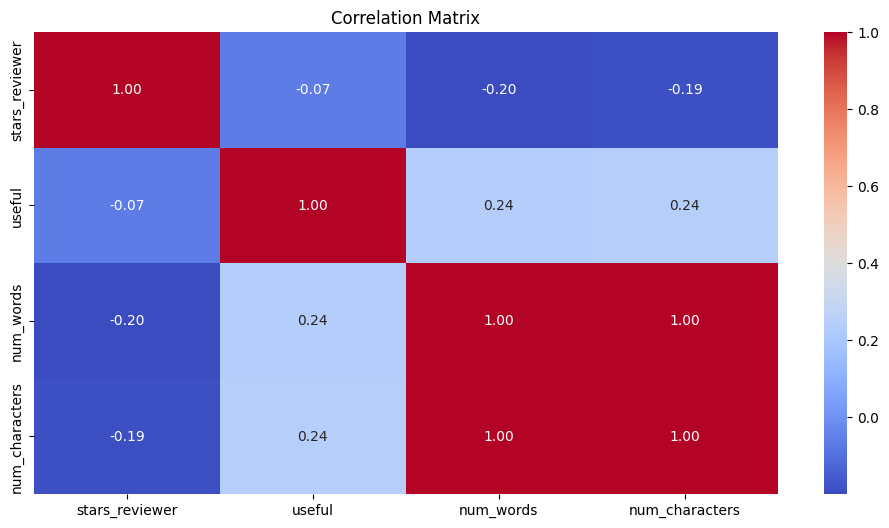

In [ ]:
correlation_matrix = yelp_data[['stars_reviewer', 'useful', 'num_words', 'num_characters']].corr()
print(correlation_matrix)

plt.figure(figsize=(12, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

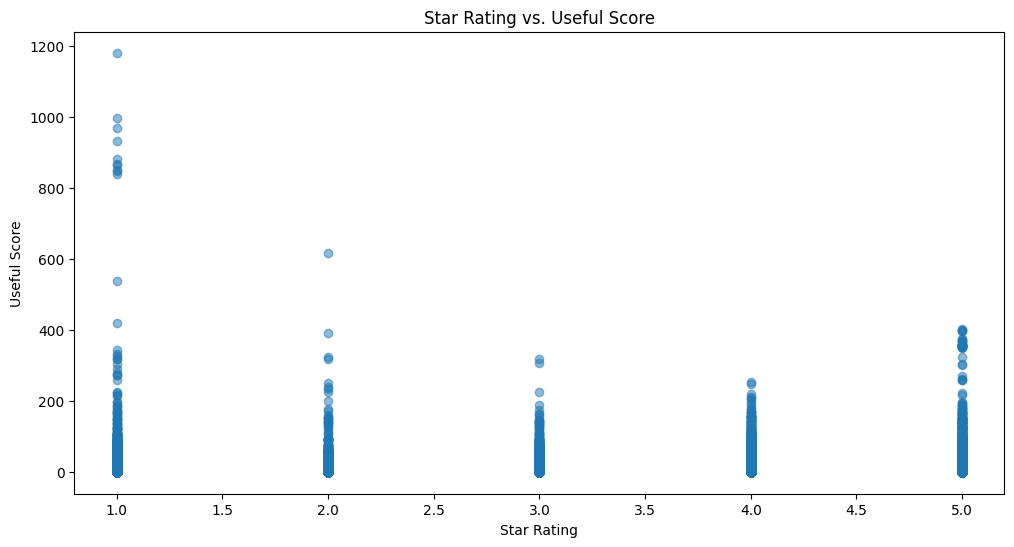

In [ ]:
## correlation between star rating and helpfulness
plt.figure(figsize=(12, 6))
plt.scatter(yelp_data['stars_reviewer'], yelp_data['useful'], alpha=0.5)
plt.title('Star Rating vs. Useful Score')
plt.xlabel('Star Rating')
plt.ylabel('Useful Score')
plt.show()

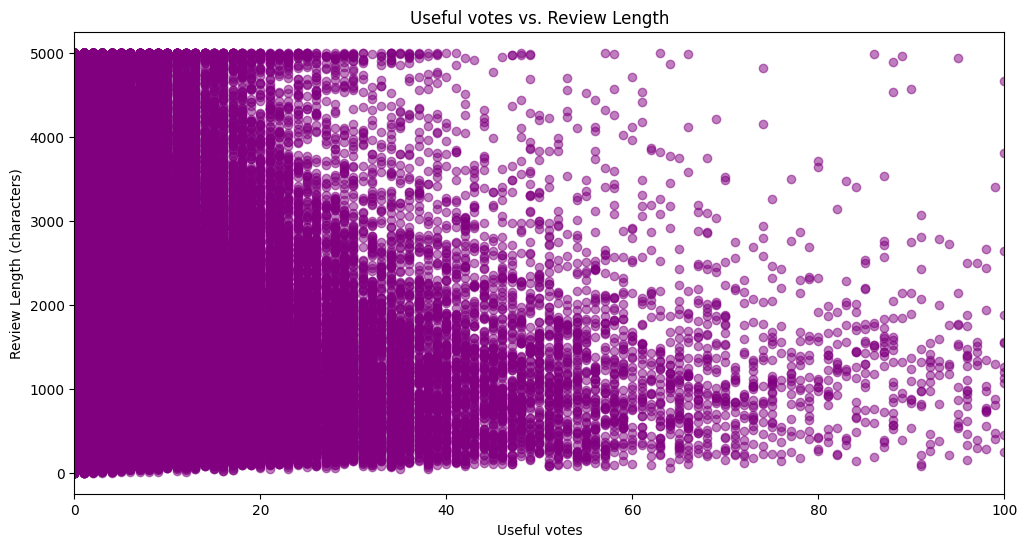

In [ ]:
plt.figure(figsize=(12, 6))
plt.scatter(yelp_data['useful'], yelp_data['num_characters'], alpha=0.5, color='purple')
plt.title('Useful votes vs. Review Length')
plt.xlabel('Useful votes')
plt.xlim(0, 100)
plt.ylabel('Review Length (characters)')
plt.show()

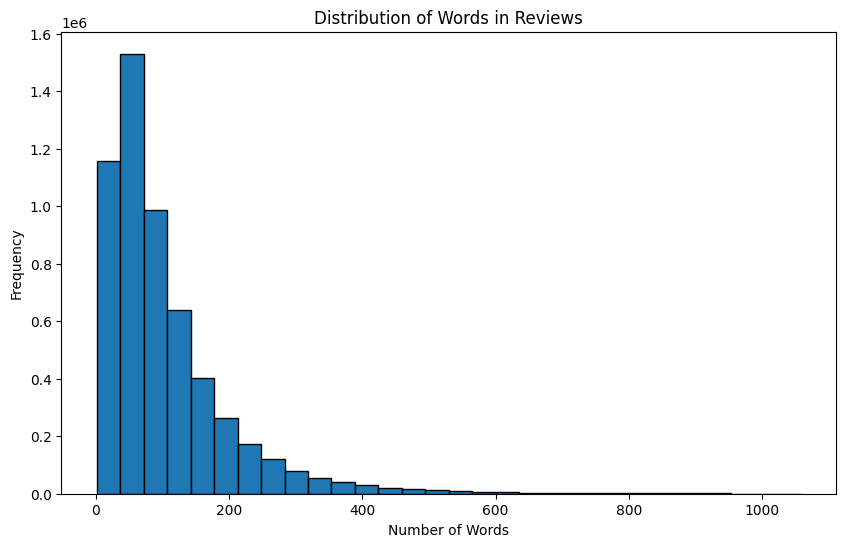

In [ ]:
fig, axes = plt.subplots(figsize=(10, 6))
axes.hist(yelp_data['num_words'], bins=30, edgecolor='black')
axes.set_title("Distribution of Words in Reviews")
axes.set_xlabel("Number of Words")
axes.set_ylabel("Frequency")
plt.show()